## Import library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.optimizers as opt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

In [2]:
def get_available_gpus():
    """
    code from http://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
    """
    from tensorflow.python.client import device_lib as _device_lib
    local_device_protos = _device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

In [3]:
get_available_gpus()

['/device:CPU:0', '/device:GPU:0']

## Define path & total number

In [4]:
path = "C:/users/cs623/.keras/datasets/personal_cats_and_dogs"
path_cat = os.path.join(path, 'cats')
path_dog = os.path.join(path, 'dogs')

In [5]:
num_cats = len(os.listdir(path_cat))
num_dogs = len(os.listdir(path_dog))
total_img_num = num_cats + num_dogs
print('total cat images:', num_cats)
print('total dog images:', num_dogs)
print('total images:', total_img_num)

total cat images: 1500
total dog images: 2172
total images: 3672


## Train test split

In [6]:
batch_size = 100
epochs = 30
IMG_HEIGHT = 120
IMG_WIDTH = 120
split = 0.2
total_val = total_img_num * split
total_train = total_img_num - total_val

In [7]:
# Generator

train_datagen = ImageDataGenerator(
    rescale=1./255,rotation_range=40, # Angle, 0-180
    width_shift_range=0.2, # horizontal shifting
    height_shift_range=0.2, # vertical shifting
    shear_range=0.2, # Shearing
    zoom_range=0.2, # Zooming
    horizontal_flip=True, # Flipping
    validation_split=split
)

#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,

In [8]:
# Load images from the disk, applies rescaling, and resizes the images

train_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='validation') # set as validation data

Found 2938 images belonging to 2 classes.
Found 734 images belonging to 2 classes.


## Sample visualisation

In [9]:
sample_img_train, sample_label_train = next(train_generator)

In [10]:
def plotImg(img):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for i, a in zip(img, axes):
        a.imshow(i)
        a.axis("off")
    plt.tight_layout()
    plt.show()

In [11]:
# plotImg(sample_img_train[:15])

## Model

In [12]:
VGGNet = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    # Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax'),
    Dense(1, activation='sigmoid'),
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [14]:
sgd = opt.SGD(lr=1e-2, decay=1e-6, momentum=0.8, nesterov=True)

In [15]:
model.compile(optimizer=sgd,
             loss='binary_crossentropy',
             metrics=['accuracy'],
             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

## Train model

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
with tf.device('/gpu:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = total_train // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = total_val // batch_size     
    )

Epoch 1/30
29/29 [==============================] - 58s 2s/step - loss: 0.6664 - acc: 0.5839 - val_loss: 0.6247 - val_acc: 0.5943
Epoch 2/30
29/29 [==============================] - 20s 706ms/step - loss: 0.6504 - acc: 0.5930 - val_loss: 0.6079 - val_acc: 0.6043
Epoch 3/30
29/29 [==============================] - 19s 663ms/step - loss: 0.6385 - acc: 0.6011 - val_loss: 0.5756 - val_acc: 0.6143
Epoch 4/30
29/29 [==============================] - 19s 645ms/step - loss: 0.6302 - acc: 0.6082 - val_loss: 0.5485 - val_acc: 0.6943
Epoch 5/30
29/29 [==============================] - 18s 635ms/step - loss: 0.6214 - acc: 0.6230 - val_loss: 0.5312 - val_acc: 0.6971
Epoch 6/30
29/29 [==============================] - 18s 616ms/step - loss: 0.6187 - acc: 0.6261 - val_loss: 0.5248 - val_acc: 0.6871
Epoch 7/30
29/29 [==============================] - 17s 602ms/step - loss: 0.6156 - acc: 0.6244 - val_loss: 0.5619 - val_acc: 0.7514
Epoch 8/30
29/29 [==============================] - 19s 656ms/step - los

## Result visualisation 

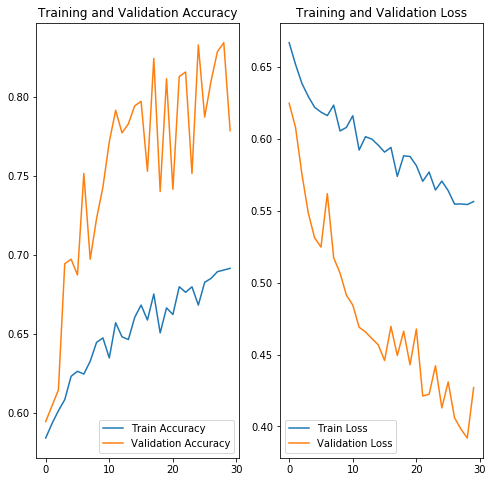

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()